In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat
from scipy import signal
from ordpy import renyi_complexity_entropy as RE
from ordpy import renyi_entropy
from ordpy import permutation_entropy
from neurodsp.burst import detect_bursts_dual_threshold as DBDT
from neurodsp.burst import compute_burst_stats
import scipy.stats
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

sns.set_theme()
%matplotlib inline

ModuleNotFoundError: ignored

In [ ]:


def band_filter(data, low, high, rate):
    b, a = signal.butter(4, [low, high], btype='band', fs=rate)
    return signal.filtfilt(b, a, data)


def notch_filter(data, freq, rate):
    b, a = signal.iirnotch(freq, 30, fs=rate)
    return signal.filtfilt(b, a, data)


def filter_data(data):
    temp = band_filter(data, 1, 80, 250)
    temp = notch_filter(temp, 50, 250)
    return notch_filter(temp, 60, 250)


def read_file(path):
    frame = pd.read_csv(path, delimiter=',\s+', comment='%')
    data = frame.loc[:, ['EXG Channel 2', 'EXG Channel 4']].values.T
    for i in range(len(data)): data[i] = filter_data(data[i])
    return data


def split_signal(data, meta, offset=0):
    start = offset * 250
    output, target = [], []
    for level, duration in meta:
        end = start + duration * 250
        output.append(data[:, start:end])
        target.append(level)
        start = end
    return output, np.array(target)

def plot_data(data):
    fig, ax = plt.subplots(1, 1, figsize=(18, 5))
    ax.plot(data)
    fig.tight_layout()

def Conditioner(data , levels , duration= 120):
    Low, Medium , High = [], [] ,[]

    for k in range(len(levels)):
        if levels[k]<1 and np.shape(data[k])[1]>= 250*duration:
            Low.append(data[k][:,:duration*250])
        elif 1 <= levels[k] < 2 and np.shape(data[k])[1]>= 250*duration:
            Medium.append(data[k][:,:duration*250])
        elif levels[k]>=2 and np.shape(data[k])[1]>= 250*duration:
            High.append(data[k][:,:duration*250])
    return Low , Medium , High

def WindowingBDT(data, window = 5,ThrH=2, ThrL= 1, duration= 0.5 ):
    d = []
    for j in data:
        for i in range(0,24):
            d.append(DBDT(j[i*window*250:(i+1)*window*250], dual_thresh=(ThrH,ThrL), fs=250, min_burst_duration=duration, avg_type='median'))

    return np.array(d).reshape(10,24,1250)

def StatDBT(data):

    a, f = [] , []
    for i in data:
        for j in i:
            f.append(compute_burst_stats(j, 250))
    f = np.array(f).reshape(10,24)

    for m in f:
        for n in m:

            a.append(n['n_bursts'])
    return  np.sum(np.array(a).reshape(10,24), axis =1)




In [ ]:
path = 'Dataset-Sleep/FinchOne/OpenBCI-RAW-2023-04-16_16-53-40.txt'
meta = [(1, 180), (.6, 120), (.4, 120), (.6, 120), (1, 150), (1.5, 150), (2, 150), (.2, 150)]
data1 = read_file(path)
signal1, level1 = split_signal(data1, meta)


path = 'Dataset-Sleep/FichTwo/OpenBCI-RAW-2023-04-17_17-05-56.txt'
meta = [(1.5, 150), (1, 80), (1.5, 190), (2, 120), (2.5, 160), (2, 120), (1.5, 128), (1, 132), (.6, 126), (.4, 124)]
data2 = read_file(path)
signal2, level2 = split_signal(data2, meta, 480)

path = 'Dataset-Sleep/FinchThree-1,2/OpenBCI-RAW-2023-05-23_11-33-40.txt'
meta = [(2, 150), (1, 80), (1.5, 190), (2, 120), (2.5, 160), (2, 120), (1.5, 128), (1, 132), (.6, 126), (.4, 124)]
data31 = read_file(path)
signal31, level31 = split_signal(data31, meta)


path = 'Dataset-Sleep/FinchThree-1,2/OpenBCI-RAW-2023-05-23_11-57-18.txt'
meta = [(2, 120)]
data32 = read_file(path)
signal32, level32 = split_signal(data32, meta)

path = 'Dataset-Sleep/FinchFour-1/OpenBCI-RAW-2023-05-23_15-47-21.txt'
meta = [(1.5, 120), (1, 90), (1.5, 120), (2, 120), (2.5, 120)]
data41 = read_file(path)
signal41, level41 = split_signal(data41, meta, offset = 150)


path = 'Dataset-Sleep/FinchFour_2/OpenBCI-RAW-2023-05-23_16-03-43.txt'
meta = [(2, 120), (1.5, 120), (1, 120), (.6, 120), (.4, 120)]
data42 = read_file(path)
signal42, level42 = split_signal(data42, meta)


C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_18760\4186558406.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_18760\4186558406.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_18760\4186558406.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as reg

In [ ]:
# Make high medium and low conditions

s1 = Conditioner(signal1, level1, duration= 120)
s2 = Conditioner(signal2, level2, duration= 120)
s31 = Conditioner(signal31, level31, duration= 120)
s32 = Conditioner(signal32, level32, duration= 120)
s41 = Conditioner(signal41, level41, duration= 120)
s42 = Conditioner(signal42, level42, duration= 120)



In [ ]:
# gather in low , medium and high for the two channels, Just for 10 of them

LowC1 = np.concatenate((s1[0],s2[0],s31[0],s42[0]),axis = 0)[:10,0]
MediumC1 = np.concatenate((s1[1],s2[1],s31[1], s41[1],s42[1]),axis = 0)[:10,0]
HighC1 = np.concatenate((s1[2],s2[2],s31[2],s32[2],s41[2],s42[2]),axis = 0)[:10,0]

LowC2 = np.concatenate((s1[0],s2[0],s31[0],s42[0]),axis = 0)[:10,1]
MediumC2 = np.concatenate((s1[1],s2[1],s31[1], s41[1],s42[1]),axis = 0)[:10,1]
HighC2 = np.concatenate((s1[2],s2[2],s31[2],s32[2],s41[2],s42[2]),axis = 0)[:10,1]



In [ ]:
#compute number of burst for windowed data in each high medium and low

NLC1 = StatDBT(WindowingBDT(LowC1,ThrH=2, ThrL= 1, duration = 1))
NMC1 = StatDBT(WindowingBDT(MediumC1,ThrH=2, ThrL= 1,duration = 1))
NHC1 = StatDBT(WindowingBDT(HighC1,ThrH=2, ThrL= 1,duration = 1))

print(sum(NLC1), sum(NMC1), sum(NHC1) )
print(NLC1, NMC1, NHC1 )


18 52 79
[2 3 6 5 1 1 0 0 0 0] [ 2  2  8  9  8 10  1  0 10  2] [ 8 12 13  5  1  9  9 10  2 10]


In [ ]:
print(mannwhitneyu(NLC1,NMC1))
print(mannwhitneyu(NLC1,NHC1))
print(mannwhitneyu(NHC1,NMC1))

MannwhitneyuResult(statistic=23.5, pvalue=0.046308845298842244)
MannwhitneyuResult(statistic=10.0, pvalue=0.0026441991335884076)
MannwhitneyuResult(statistic=69.0, pvalue=0.15737101598285252)


In [ ]:
NLC2 = StatDBT(WindowingBDT(LowC2,ThrH=2, ThrL= 1,duration = 1))
NMC2 = StatDBT(WindowingBDT(MediumC2,ThrH=2, ThrL= 1,duration = 1))
NHC2 = StatDBT(WindowingBDT(HighC2,ThrH=2, ThrL= 1,duration = 1))

print(sum(NLC2), sum(NMC2), sum(NHC2) )

23 63 73


In [ ]:
print(mannwhitneyu(NLC2,NMC2))
print(mannwhitneyu(NLC2,NHC2))
print(mannwhitneyu(NHC2,NMC2))

MannwhitneyuResult(statistic=15.0, pvalue=0.008392726228835053)
MannwhitneyuResult(statistic=15.0, pvalue=0.008268026437262288)
MannwhitneyuResult(statistic=58.5, pvalue=0.542605694896457)


In [ ]:
# Example plot
R31 = np.asarray(WindoBDT(signal31[6][0],ThrH=2, ThrL= 1))
R32 = np.asarray(WindoBDT(signal31[9][0],ThrH=2, ThrL= 1))

R31 = R31.flatten('C')
R32 = R32.flatten('C')



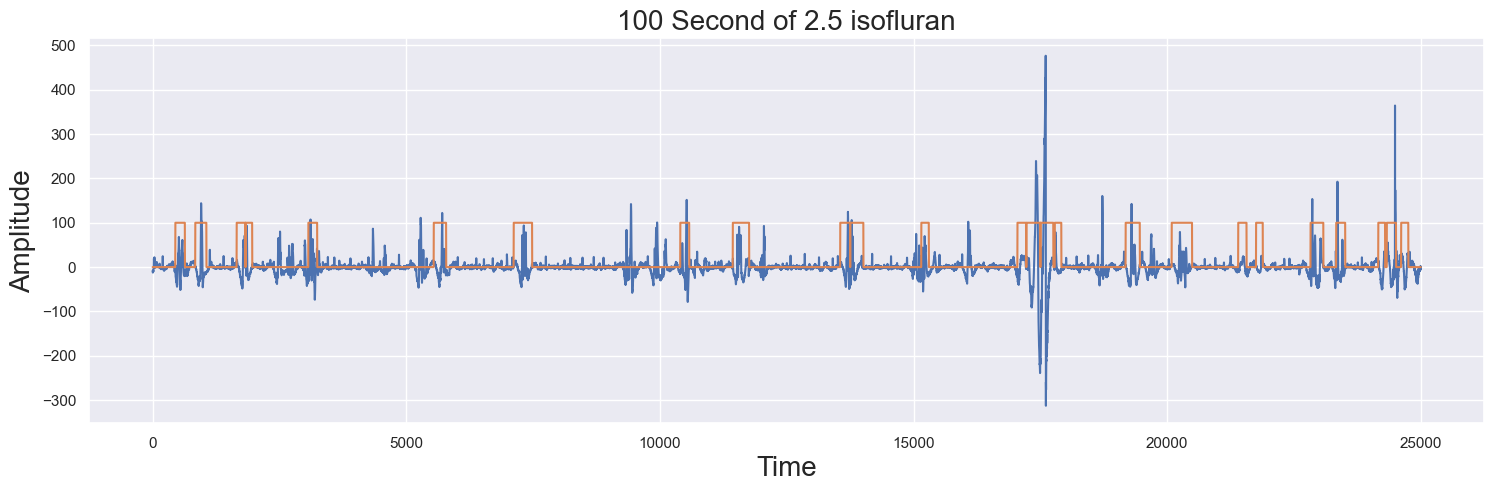

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.title('100 Second of 2.5 isofluran', size = 20)
plt.xlabel('Time', size = 20)
plt.ylabel('Amplitude', size = 20)

plt.plot(signal31[4][0][:25000])
plt.plot( R31[:25000]*100)

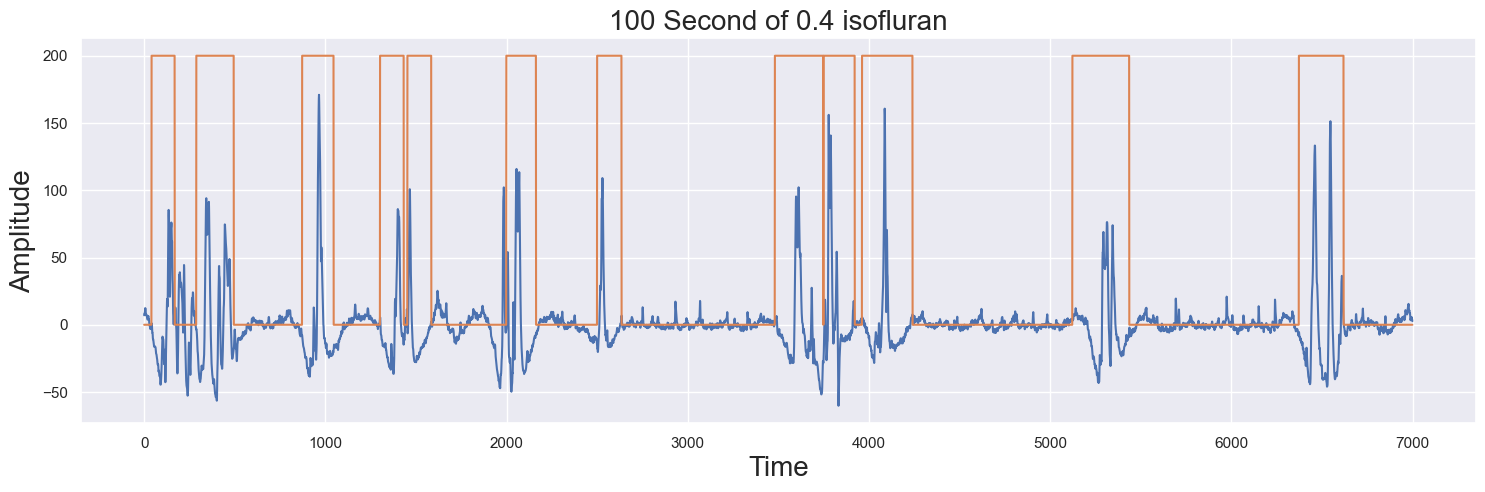

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.title('100 Second of 0.4 isofluran', size = 20)
plt.xlabel('Time', size = 20)
plt.ylabel('Amplitude', size = 20)

plt.plot(signal31[6][0][10000:17000])
plt.plot(200 * R32[10000:17000])

NameError: name 'output2' is not defined

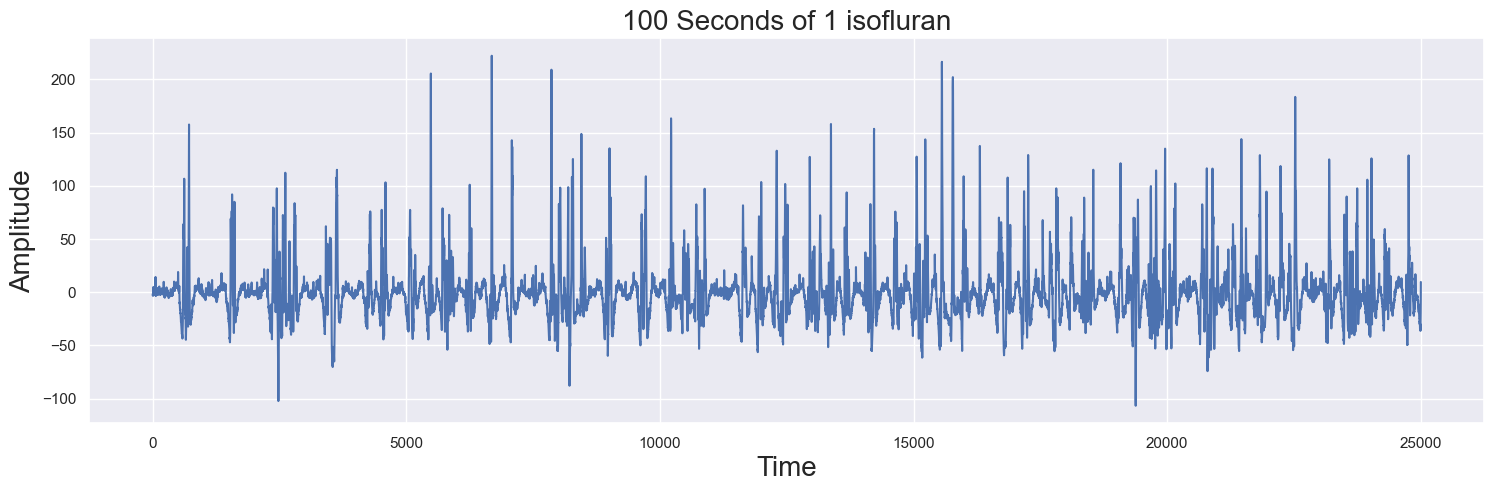

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.title('100 Seconds of 1 isofluran', size = 20)
plt.xlabel('Time', size = 20)
plt.ylabel('Amplitude', size = 20)

plt.plot(signal31[7][0][:100*250])
plt.plot(signal31[7][0][:100*250] * output2)

In [ ]:
burst_stats = compute_burst_stats(output, 250)

# Print out burst statistic information
print('\t Stat of Iso 2.5')
for key, val in burst_stats.items():
    print('{:15} \t: {}'.format(key, val))

In [ ]:
burst_stats = compute_burst_stats(output2, 250)

# Print out burst statistic information
print('\t Stat of Iso 1')
for key, val in burst_stats.items():
    print('{:15} \t: {}'.format(key, val))

In [ ]:
plt.plot(signal31[7][0][1000:2000])

In [ ]:
A310 = np.array(np.copy(signal31[7][0][10000:12000]))
A325 = np.array(np.copy(signal31[4][0][10000:12000]))

In [ ]:
print(np.max(A304) / np.mean(A304))
print(np.max(A325) / np.mean(A325))


In [ ]:
def Burstconvertor(data, thresh, facilator):

    d = []
    for i in data:
        if i>thresh*np.mean(data) or i<-(thresh/facilator)*np.mean(data):
            d.append(1)
        else:
            d.append(0)
    return d

In [ ]:
BA304 = Burstconvertor(A304, (np.max(A304) / np.mean(A304))/4 ,2)
BA325 = Burstconvertor(A325, (np.max(A325) / np.mean(A325))/6, 2)

In [ ]:
plot_data(BA304)
plt.title('2 minutes of 0.4 isofluran', size = 20)
plt.xlabel('Duration', size = 20)
plt.ylabel('Burst Occurance', size = 20)
plot_data(A304)

In [ ]:
plot_data(BA325)
plt.title('2 minutes of 2.5 isofluran', size = 20)
plt.xlabel('Duration', size = 20)
plt.ylabel('Burst Occurance', size = 20)
plot_data(A325)
